In [3]:
# Import required libraries
import os
import folium
import earthaccess
import warnings
import folium.plugins
import pandas as pd
import geopandas as gpd
import math

from branca.element import Figure
from IPython.display import display
from shapely import geometry
from skimage import io
from datetime import timedelta
from shapely.geometry.polygon import orient
from matplotlib import pyplot as plt

In [4]:
polygon = gpd.read_file('../../Cape Fire Analysis/Cape Floristic Region Data/Cape_Floristic_Region.geojson')
polygon.crs


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [5]:
polygon

,OBJECTID,NAME,TYPE,NAME_TYPE,Color,Shape__Area,Shape__Length,geometry
0,4,Cape Floristic Region,hotspot_area,Cape Floristic Region_hotspot_area,1,1.129779e+11,1.110659e+07,"MULTIPOLYGON (((17.67123 -29.86328, 17.66259 -..."


In [6]:
# Merge all Polygon geometries and create external boundary
roi_poly = polygon.unary_union.envelope
# Re-order vertices to counterclockwise
roi_poly = orient(roi_poly, sign=1.0)

In [7]:
df = pd.DataFrame({"Name":["ROI Bounding Box"]})
cfr_bbox = gpd.GeoDataFrame({"Name":["ROI Bounding Box"], "geometry":[roi_poly]},crs="EPSG:4326")
cfr_bbox

,Name,geometry
0,ROI Bounding Box,"POLYGON ((17.42036 -34.83983, 25.70225 -34.839..."


In [8]:
def convert_bounds(bbox, invert_y=False):
    """
    Helper method for changing bounding box representation to leaflet notation

    ``(lon1, lat1, lon2, lat2) -> ((lat1, lon1), (lat2, lon2))``
    """
    x1, y1, x2, y2 = bbox
    if invert_y:
        y1, y2 = y2, y1
    return ((y1, x1), (y2, x2))

    

In [9]:
fig = Figure(width="750px", height="375px")
map1 = folium.Map(tiles='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}', attr='Google')
fig.add_child(map1)

# Add Convex Hull Polygon
folium.GeoJson(cfr_bbox,
                name='bounding_box',
                ).add_to(map1)

map1.add_child(folium.LayerControl())
map1.fit_bounds(bounds=convert_bounds(polygon.unary_union.bounds))
display(fig)


In [10]:
roi = list(roi_poly.exterior.coords)


In [11]:
emit_collection_query = earthaccess.collection_query().keyword('EMIT L2A Reflectance')
emit_collection_query.fields(['ShortName','EntryTitle','Version']).get()


[{
   "meta": {
     "concept-id": "C2408750690-LPCLOUD",
     "granule-count": 61723,
     "provider-id": "LPCLOUD"
   },
   "umm": {
     "ShortName": "EMITL2ARFL",
     "EntryTitle": "EMIT L2A Estimated Surface Reflectance and Uncertainty and Masks 60 m V001",
     "Version": "001"
   }
 }]

In [12]:
date_range = ('2023-02-01','2023-2-28')


In [13]:
concept_ids = ['C2408750690-LPCLOUD']

In [14]:
results = earthaccess.search_data(
    concept_id=concept_ids,
    polygon=roi,
    temporal=('2023-1-01','2023-1-31'),
    count = 584,
    cloud_cover = (0,10) 
)
    

Granules found: 39


In [15]:

def get_shapely_object(result:earthaccess.results.DataGranule):
    # Get Geometry Keys
    geo = result['umm']['SpatialExtent']['HorizontalSpatialDomain']['Geometry']
    keys = geo.keys()

    if 'BoundingRectangles' in keys:
        bounding_rectangle = geo['BoundingRectangles'][0]
        # Create bbox tuple
        bbox_coords = (bounding_rectangle['WestBoundingCoordinate'],bounding_rectangle['SouthBoundingCoordinate'],
                    bounding_rectangle['EastBoundingCoordinate'],bounding_rectangle['NorthBoundingCoordinate'])
        # Create shapely geometry from bbox
        shape = geometry.box(*bbox_coords, ccw=True)
    elif 'GPolygons' in keys:
        points = geo['GPolygons'][0]['Boundary']['Points']
        # Create shapely geometry from polygons
        shape = geometry.Polygon([[p['Longitude'],p['Latitude']] for p in points])
    else:
         raise ValueError('Provided result does not contain bounding boxes/polygons or is incompatible.')
    return(shape)

# Retrieve png browse image if it exists or first jpg in list of urls
def get_png(result:earthaccess.results.DataGranule):
    https_links = [link for link in result.dataviz_links() if 'https' in link]
    if len(https_links) == 1:
        browse = https_links[0]
    elif len(https_links) == 0:
        browse = 'no browse image'
        warnings.warn(f"There is no browse imagery for {result['umm']['GranuleUR']}.")
    else:
        browse = [png for png in https_links if '.png' in png][0]
    return(browse)

In [16]:
# Create Dataframe of Results Metadata
results_df = pd.json_normalize(results)
# Create shapely polygons for result
geometries = [get_shapely_object(results[index]) for index in results_df.index.to_list()]
# Convert to GeoDataframe
gdf = gpd.GeoDataFrame(results_df, geometry=geometries, crs="EPSG:4326")
# Remove results df, no longer needed
del results_df
# Add browse imagery links
gdf['browse'] = [get_png(granule) for granule in results]
gdf['shortname'] = [result['umm']['CollectionReference']['ShortName'] for result in results]
# Preview GeoDataframe
print(f'{gdf.shape[0]} granules total')


39 granules total


In [17]:
gdf

,size,meta.concept-type,meta.concept-id,meta.revision-id,meta.native-id,meta.provider-id,meta.format,meta.revision-date,umm.TemporalExtent.RangeDateTime.BeginningDateTime,umm.TemporalExtent.RangeDateTime.EndingDateTime,...,umm.DataGranule.DayNightFlag,umm.DataGranule.ArchiveAndDistributionInformation,umm.DataGranule.ProductionDateTime,umm.Platforms,umm.MetadataSpecification.URL,umm.MetadataSpecification.Name,umm.MetadataSpecification.Version,geometry,browse,shortname
0,3579.872540,granule,G2621941049-LPCLOUD,1,EMIT_L2A_RFL_001_20230107T082503_2300705_010,LPCLOUD,application/vnd.nasa.cmr.umm+json,2023-02-27T19:32:40.885Z,2023-01-07T08:25:03Z,2023-01-07T08:25:15Z,...,Day,[{'Name': 'EMIT_L2A_RFL_001_20230107T082503_23...,2023-02-27T19:22:12Z,"[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.5,UMM-G,1.6.5,"POLYGON ((18.23870 -28.49792, 17.69559 -29.066...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,EMITL2ARFL
1,3579.853838,granule,G2621941455-LPCLOUD,1,EMIT_L2A_RFL_001_20230107T082515_2300705_011,LPCLOUD,application/vnd.nasa.cmr.umm+json,2023-02-27T19:33:47.290Z,2023-01-07T08:25:15Z,2023-01-07T08:25:27Z,...,Day,[{'Name': 'EMIT_L2A_RFL_001_20230107T082515_23...,2023-02-27T19:22:47Z,"[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.5,UMM-G,1.6.5,"POLYGON ((18.80566 -29.03512, 18.26646 -29.609...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,EMITL2ARFL
2,3579.503963,granule,G2621941650-LPCLOUD,1,EMIT_L2A_RFL_001_20230107T082527_2300705_012,LPCLOUD,application/vnd.nasa.cmr.umm+json,2023-02-27T19:34:09.858Z,2023-01-07T08:25:27Z,2023-01-07T08:25:39Z,...,Day,[{'Name': 'EMIT_L2A_RFL_001_20230107T082527_23...,2023-02-27T19:22:47Z,"[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.5,UMM-G,1.6.5,"POLYGON ((19.37742 -29.56899, 18.84355 -30.149...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,EMITL2ARFL
3,3579.813070,granule,G2621944360-LPCLOUD,1,EMIT_L2A_RFL_001_20230107T082539_2300705_013,LPCLOUD,application/vnd.nasa.cmr.umm+json,2023-02-27T19:38:00.215Z,2023-01-07T08:25:39Z,2023-01-07T08:25:50Z,...,Day,[{'Name': 'EMIT_L2A_RFL_001_20230107T082539_23...,2023-02-27T19:24:16Z,"[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.5,UMM-G,1.6.5,"POLYGON ((19.95217 -30.09955, 19.42645 -30.685...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,EMITL2ARFL
4,3579.977796,granule,G2621944396-LPCLOUD,1,EMIT_L2A_RFL_001_20230107T082550_2300705_014,LPCLOUD,application/vnd.nasa.cmr.umm+json,2023-02-27T19:38:06.107Z,2023-01-07T08:25:50Z,2023-01-07T08:26:02Z,...,Day,[{'Name': 'EMIT_L2A_RFL_001_20230107T082550_23...,2023-02-27T19:24:16Z,"[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.5,UMM-G,1.6.5,"POLYGON ((20.54642 -30.62619, 20.01682 -31.218...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,EMITL2ARFL
5,3580.095710,granule,G2621944423-LPCLOUD,1,EMIT_L2A_RFL_001_20230107T082602_2300705_015,LPCLOUD,application/vnd.nasa.cmr.umm+json,2023-02-27T19:38:15.369Z,2023-01-07T08:26:02Z,2023-01-07T08:26:14Z,...,Day,[{'Name': 'EMIT_L2A_RFL_001_20230107T082602_23...,2023-02-27T19:24:16Z,"[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.5,UMM-G,1.6.5,"POLYGON ((21.13803 -31.15001, 20.61411 -31.747...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,EMITL2ARFL
6,3579.942201,granule,G2621944230-LPCLOUD,1,EMIT_L2A_RFL_001_20230107T082614_2300705_016,LPCLOUD,application/vnd.nasa.cmr.umm+json,2023-02-27T19:37:42.845Z,2023-01-07T08:26:14Z,2023-01-07T08:26:26Z,...,Day,[{'Name': 'EMIT_L2A_RFL_001_20230107T082614_23...,2023-02-27T19:24:16Z,"[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.5,UMM-G,1.6.5,"POLYGON ((21.74003 -31.67058, 21.21900 -32.274...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,EMITL2ARFL


In [21]:
# Plot Using Folium

# Create Figure and Select Background Tiles
fig = Figure(width="750px", height="375px")
map1 = folium.Map(tiles='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}', attr='Google')
fig.add_child(map1)

# Plot STAC EMITL2ARFL Results - note we must drop the datetime_obj columns for this to work
emit_gdf.drop(columns=['datetime_obj']).explore(
    "granule",
    categorical=True,
    tooltip=[
        "granule",
        "start_datetime",
        "cloud_cover",
    ],
    popup=True,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="EMIT",
    m=map1,
    legend=False
)



# Plot Region of Interest
polygon.explore(
    popup=False,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="Region of Interest",
    m=map1
)

folium.GeoJson(roi_poly,
                name='bounding_box',
                ).add_to(map1)

map1.fit_bounds(bounds=convert_bounds(gdf.unary_union.bounds))
map1.add_child(folium.LayerControl())
display(fig)

NameError: name 'emit_gdf' is not defined

In [80]:
gdf.columns


Index(['size', 'meta.concept-type', 'meta.concept-id', 'meta.revision-id',
       'meta.native-id', 'meta.provider-id', 'meta.format',
       'meta.revision-date',
       'umm.TemporalExtent.RangeDateTime.BeginningDateTime',
       'umm.TemporalExtent.RangeDateTime.EndingDateTime', 'umm.GranuleUR',
       'umm.AdditionalAttributes',
       'umm.SpatialExtent.HorizontalSpatialDomain.Geometry.GPolygons',
       'umm.ProviderDates', 'umm.CollectionReference.ShortName',
       'umm.CollectionReference.Version', 'umm.PGEVersionClass.PGEName',
       'umm.PGEVersionClass.PGEVersion', 'umm.RelatedUrls', 'umm.CloudCover',
       'umm.DataGranule.DayNightFlag',
       'umm.DataGranule.ArchiveAndDistributionInformation',
       'umm.DataGranule.ProductionDateTime', 'umm.Platforms',
       'umm.MetadataSpecification.URL', 'umm.MetadataSpecification.Name',
       'umm.MetadataSpecification.Version', 'geometry', 'browse', 'shortname'],
      dtype='object')

In [106]:
keep_cols = ['meta.concept-id','meta.native-id', 'umm.TemporalExtent.RangeDateTime.BeginningDateTime','umm.TemporalExtent.RangeDateTime.EndingDateTime','umm.CloudCover','umm.DataGranule.DayNightFlag','geometry','browse', 'shortname']
# Remove unneeded columns
gdf = gdf[gdf.columns.intersection(keep_cols)]
gdf.head()

,meta.concept-id,meta.native-id,umm.TemporalExtent.RangeDateTime.BeginningDateTime,umm.TemporalExtent.RangeDateTime.EndingDateTime,umm.CloudCover,umm.DataGranule.DayNightFlag,geometry,browse,shortname
0,G2621941049-LPCLOUD,EMIT_L2A_RFL_001_20230107T082503_2300705_010,2023-01-07T08:25:03Z,2023-01-07T08:25:15Z,0,Day,"POLYGON ((18.23870 -28.49792, 17.69559 -29.066...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,EMITL2ARFL
1,G2621941455-LPCLOUD,EMIT_L2A_RFL_001_20230107T082515_2300705_011,2023-01-07T08:25:15Z,2023-01-07T08:25:27Z,0,Day,"POLYGON ((18.80566 -29.03512, 18.26646 -29.609...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,EMITL2ARFL
2,G2621941650-LPCLOUD,EMIT_L2A_RFL_001_20230107T082527_2300705_012,2023-01-07T08:25:27Z,2023-01-07T08:25:39Z,3,Day,"POLYGON ((19.37742 -29.56899, 18.84355 -30.149...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,EMITL2ARFL
3,G2621944360-LPCLOUD,EMIT_L2A_RFL_001_20230107T082539_2300705_013,2023-01-07T08:25:39Z,2023-01-07T08:25:50Z,3,Day,"POLYGON ((19.95217 -30.09955, 19.42645 -30.685...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,EMITL2ARFL
4,G2621944396-LPCLOUD,EMIT_L2A_RFL_001_20230107T082550_2300705_014,2023-01-07T08:25:50Z,2023-01-07T08:26:02Z,0,Day,"POLYGON ((20.54642 -30.62619, 20.01682 -31.218...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,EMITL2ARFL


In [107]:
gdf.rename(columns = {'meta.concept-id':'concept_id','meta.native-id':'granule',
                       'umm.TemporalExtent.RangeDateTime.BeginningDateTime':'start_datetime',
                      'umm.TemporalExtent.RangeDateTime.EndingDateTime':'end_datetime',
                      'umm.CloudCover':'cloud_cover',
                      'umm.DataGranule.DayNightFlag':'day_night'}, inplace=True)
gdf.head()

,concept_id,granule,start_datetime,end_datetime,cloud_cover,day_night,geometry,browse,shortname
0,G2621941049-LPCLOUD,EMIT_L2A_RFL_001_20230107T082503_2300705_010,2023-01-07T08:25:03Z,2023-01-07T08:25:15Z,0,Day,"POLYGON ((18.23870 -28.49792, 17.69559 -29.066...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,EMITL2ARFL
1,G2621941455-LPCLOUD,EMIT_L2A_RFL_001_20230107T082515_2300705_011,2023-01-07T08:25:15Z,2023-01-07T08:25:27Z,0,Day,"POLYGON ((18.80566 -29.03512, 18.26646 -29.609...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,EMITL2ARFL
2,G2621941650-LPCLOUD,EMIT_L2A_RFL_001_20230107T082527_2300705_012,2023-01-07T08:25:27Z,2023-01-07T08:25:39Z,3,Day,"POLYGON ((19.37742 -29.56899, 18.84355 -30.149...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,EMITL2ARFL
3,G2621944360-LPCLOUD,EMIT_L2A_RFL_001_20230107T082539_2300705_013,2023-01-07T08:25:39Z,2023-01-07T08:25:50Z,3,Day,"POLYGON ((19.95217 -30.09955, 19.42645 -30.685...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,EMITL2ARFL
4,G2621944396-LPCLOUD,EMIT_L2A_RFL_001_20230107T082550_2300705_014,2023-01-07T08:25:50Z,2023-01-07T08:26:02Z,0,Day,"POLYGON ((20.54642 -30.62619, 20.01682 -31.218...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,EMITL2ARFL


In [108]:
gdf['datetime_obj'] = pd.to_datetime(gdf['start_datetime']) 

<Axes: title={'center': 'EMITL2ARFL'}>

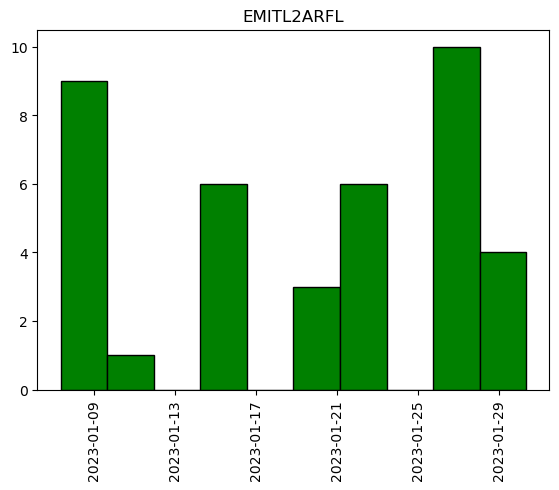

In [110]:
gdf.hist(column='datetime_obj', by='shortname', bins=10, color='green', edgecolor='black', linewidth=1, sharey=True)

<Axes: title={'center': 'EMITL2ARFL'}>

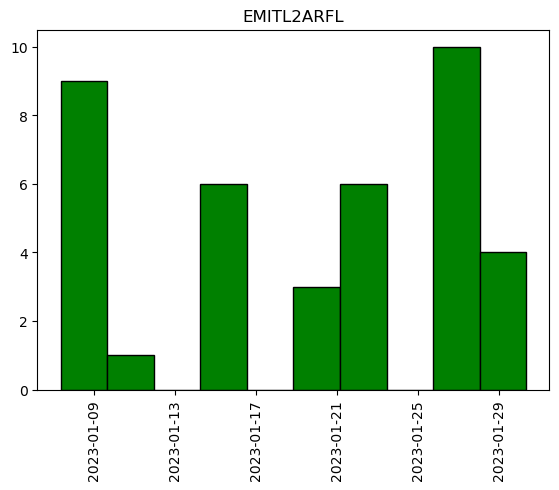

In [111]:
gdf.hist(column='datetime_obj', by='shortname', bins=10, color='green', edgecolor='black', linewidth=1, sharey=True)


In [112]:
pd.options.mode.chained_assignment = None  # default='warn'

# Split into two dataframes - ECO and EMIT
eco_gdf = gdf[gdf['granule'].str.contains('ECO')]
emit_gdf = gdf[gdf['granule'].str.contains('EMIT')]
print(f' ECOSTRESS Granules: {eco_gdf.shape[0]} \n EMIT Granules: {emit_gdf.shape[0]}')

 ECOSTRESS Granules: 0 
 EMIT Granules: 39


In [113]:

emit_gdf.head()


,concept_id,granule,start_datetime,end_datetime,cloud_cover,day_night,geometry,browse,shortname,datetime_obj
0,G2621941049-LPCLOUD,EMIT_L2A_RFL_001_20230107T082503_2300705_010,2023-01-07T08:25:03Z,2023-01-07T08:25:15Z,0,Day,"POLYGON ((18.23870 -28.49792, 17.69559 -29.066...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,EMITL2ARFL,2023-01-07 08:25:03+00:00
1,G2621941455-LPCLOUD,EMIT_L2A_RFL_001_20230107T082515_2300705_011,2023-01-07T08:25:15Z,2023-01-07T08:25:27Z,0,Day,"POLYGON ((18.80566 -29.03512, 18.26646 -29.609...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,EMITL2ARFL,2023-01-07 08:25:15+00:00
2,G2621941650-LPCLOUD,EMIT_L2A_RFL_001_20230107T082527_2300705_012,2023-01-07T08:25:27Z,2023-01-07T08:25:39Z,3,Day,"POLYGON ((19.37742 -29.56899, 18.84355 -30.149...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,EMITL2ARFL,2023-01-07 08:25:27+00:00
3,G2621944360-LPCLOUD,EMIT_L2A_RFL_001_20230107T082539_2300705_013,2023-01-07T08:25:39Z,2023-01-07T08:25:50Z,3,Day,"POLYGON ((19.95217 -30.09955, 19.42645 -30.685...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,EMITL2ARFL,2023-01-07 08:25:39+00:00
4,G2621944396-LPCLOUD,EMIT_L2A_RFL_001_20230107T082550_2300705_014,2023-01-07T08:25:50Z,2023-01-07T08:26:02Z,0,Day,"POLYGON ((20.54642 -30.62619, 20.01682 -31.218...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,EMITL2ARFL,2023-01-07 08:25:50+00:00


In [114]:
eco_gdf['intersects'] = eco_gdf.intersects(emit_gdf.unary_union)
eco_gdf = eco_gdf[eco_gdf['intersects'] == True]
print('EMIT Granules: {emit_gdf.shape[0]}')

EMIT Granules: {emit_gdf.shape[0]}


In [115]:
def concurrent_match(gdf_a:pd.DataFrame, gdf_b:pd.DataFrame, col_name:str, time_delta:timedelta):
    """
    Cross references dataframes containing a datetime object column and keeps rows in 
    each that fall within the provided timedelta of the other. Acceptable time_delta examples:
    
    months=1
    days=1
    hours=1
    minutes=1
    seconds=1 

    """
    # Match Timestamps from Dataframe A with Time-range of entries in Dataframe B
    # Create empty list
    a_list = []
    # Iterate results for product a based on index values
    for _n in gdf_b.index.to_list():
        # Find where product b is within the window of each product a result
        a_matches = (gdf_a[col_name] > gdf_b[col_name][_n]-time_delta) & (gdf_a[col_name] < gdf_b[col_name][_n]+time_delta)
        # Append list with values
        a_list.append(a_matches)
    # Match Timestamps from Dataframe B with Time-range of entries in Dataframe A
    # Create empty list
    b_list =[]
    for _m in gdf_a.index.to_list():
        # Find where product a is within the window of each product b result
        b_matches = (gdf_b[col_name] > gdf_a[col_name][_m]-time_delta) &  (gdf_b[col_name] < gdf_a[col_name][_m]+time_delta)
        # Append list with values
        b_list.append(b_matches)
    # Filter Original Dataframes by summing list of bools, 0 = outside of all time-ranges
    a_filtered = gdf_a.loc[sum(a_list) > 0]
    b_filtered = gdf_b.loc[sum(b_list) > 0]
    return(a_filtered, b_filtered)

In [116]:
# Plot Using Folium

# Create Figure and Select Background Tiles
fig = Figure(width="750px", height="375px")
map1 = folium.Map(tiles='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}', attr='Google')
fig.add_child(map1)

# Plot STAC EMITL2ARFL Results - note we must drop the datetime_obj columns for this to work
emit_gdf.drop(columns=['datetime_obj']).explore(
    "granule",
    categorical=True,
    tooltip=[
        "granule",
        "start_datetime",
        "cloud_cover",
    ],
    popup=True,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="EMIT",
    m=map1,
    legend=False
)



# Plot Region of Interest
polygon.explore(
    popup=False,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="Region of Interest",
    m=map1
)

folium.GeoJson(roi_poly,
                name='bounding_box',
                ).add_to(map1)

map1.fit_bounds(bounds=convert_bounds(gdf.unary_union.bounds))
map1.add_child(folium.LayerControl())
display(fig)

In [117]:
eco_gdf = eco_gdf[eco_gdf['granule'].str.contains("10SGD")]


In [118]:
print(f' ECOSTRESS Granules: {eco_gdf.shape[0]} \n EMIT Granules: {emit_gdf.shape[0]}')

 ECOSTRESS Granules: 0 
 EMIT Granules: 39


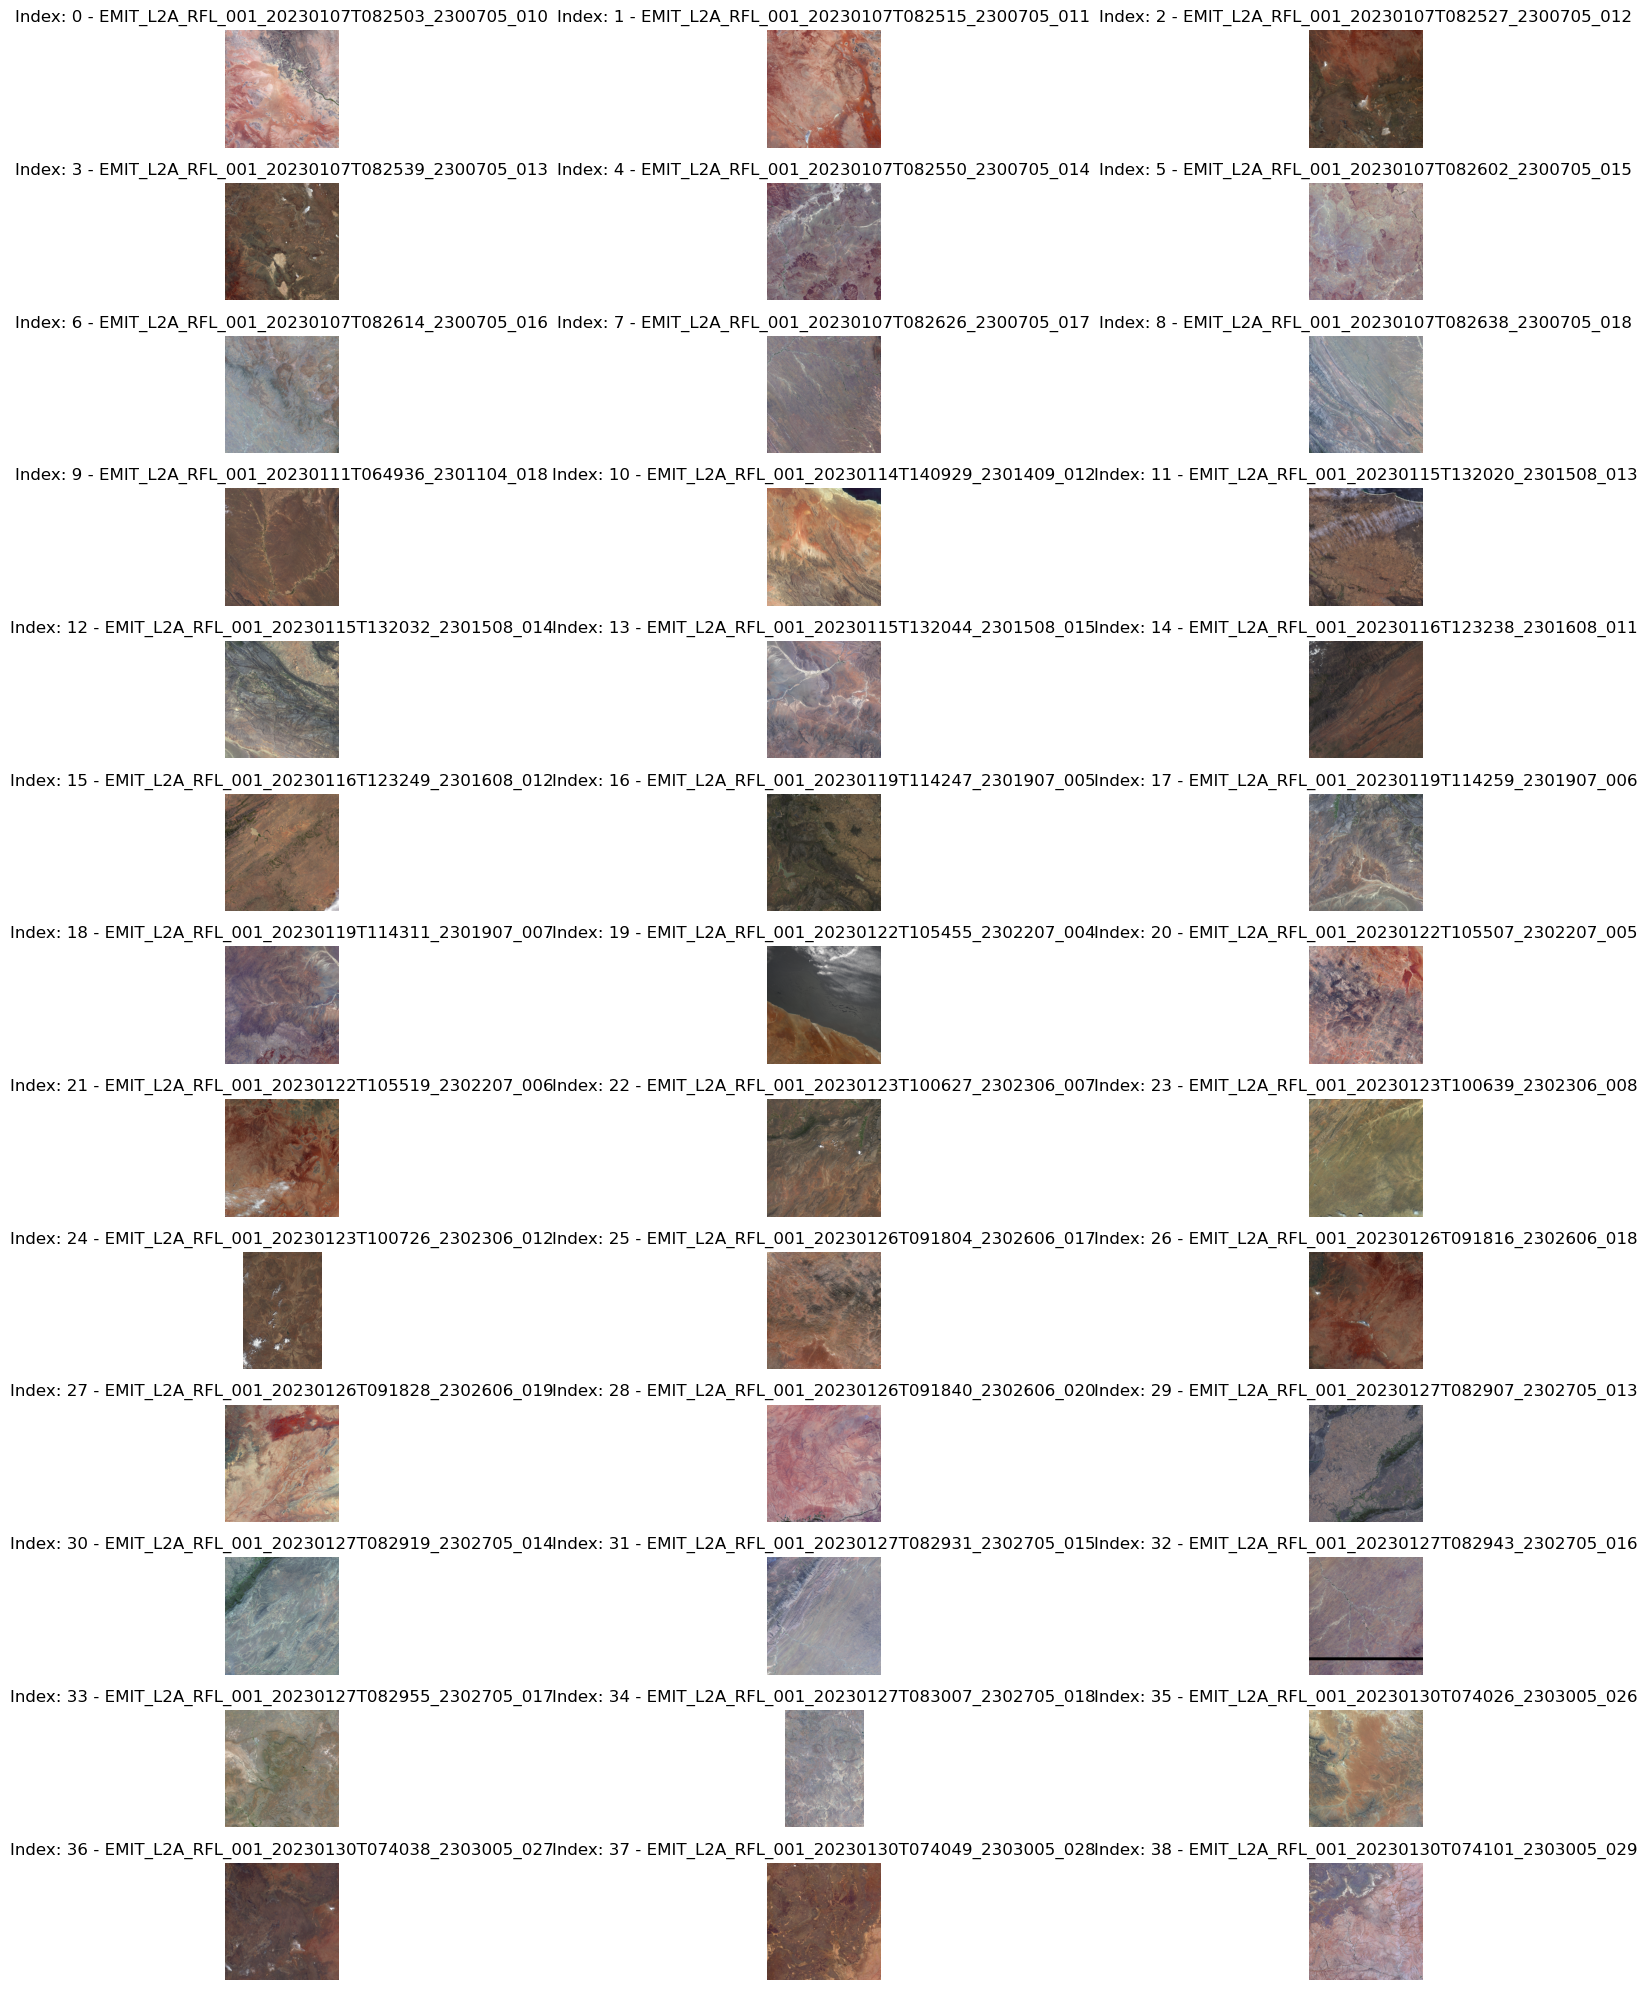

In [119]:
cols = 3
rows = math.ceil(len(emit_gdf)/cols)
fig, ax = plt.subplots(rows, cols, figsize=(20,20))
ax = ax.flatten()

for _n, index in enumerate(emit_gdf.index.to_list()):
    img = io.imread(emit_gdf['browse'][index])
    ax[_n].imshow(img)
    ax[_n].set_title(f"Index: {index} - {emit_gdf['granule'][index]}")
    ax[_n].axis('off')
plt.tight_layout()
plt.show()